In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import os
from torch.optim import Adam
from itertools import product
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import random

# Clases

In [18]:
class Datos(Dataset): 
    def __init__(self, imagenes, etiquetas):
        """
        Convierte los datos originales a tensores de Pytorch.
        
        Parameters
        --------------
        imagenes:
            Son las imagenes del dataset.
        etiquetas:
            Son las etiquetas que se usan para la calsificación
        
        Returns
        -------------
        No devuelve nada.
        """
        self.imagenes = torch.tensor(imagenes, dtype=torch.float32)
        self.etiquetas = torch.tensor(etiquetas, dtype=torch.float32)

    def __len__(self):
        """
        Calcula la cantidad de muestras de la base.
        
        Parameters
        --------------
        No recibe parámetros.
        
        Returns
        -------------
        len(self.imagenes):
            Numero total de muestras.
        """
        return len(self.imagenes)
    
    def set_imagen(self, idx, nueva_imagen):
        """
        Reemplaza la imagen en el índice dado con una nueva imagen.
        
        Parameters
        ----------
        idx : int
            Índice de la imagen a modificar.
        nueva_imagen : torch.Tensor
            Nueva imagen que reemplazará a la existente.
        """
        self.imagenes[idx] = nueva_imagen

    def set_etiqueta(self, idx, nueva_etiqueta):
        """
        Reemplaza la etiqueta en el índice dado con una nueva etiqueta.
        
        Parameters
        ----------
        idx : int
            Índice de la etiqueta a modificar.
        nueva_etiqueta : torch.Tensor
            Nueva etiqueta que reemplazará a la existente.
        """
        self.etiquetas[idx] = nueva_etiqueta
        
    def __getitem__(self, idx):
        """
        Obtener la imagen y la etiqueta de una imagen en específico.
        
        Parameters
        --------------
        idx:
            Indice de la imagen a recuperar.
        
        Returns
        -------------
        self.imagenes[idx]:
            Imagen del indice idx.
        self.etiquetas[idx]:
            Etiqueta de la imagen en el indice idx.
        """
        return self.imagenes[idx], self.etiquetas[idx]

In [19]:
# Definir el modelo
class RedNeuronal(nn.Module):
    """
    Red neuronal multicapa simple para clasificación binaria.
    Toma como entrada imágenes en escala de grises de 28x28 píxeles.
    """

    def __init__(self):
        """
        Constructor de la red neuronal.
        Define la arquitectura de la red como una secuencia de capas lineales y funciones de activación ReLU.
        """
        super().__init__()  # Llama a nn.Module para heredar correctamente
        self.net = nn.Sequential(
            nn.Flatten(),                  # Convierte (1, 28, 28) → (784)
            nn.Linear(28 * 28, 64),        # 784 → 64
            nn.ReLU(),
            nn.Linear(64, 32),             # 64 → 32
            nn.ReLU(),
            nn.Linear(32, 16),             # 32 → 16
            nn.ReLU(),
            nn.Linear(16, 1)               # 16 → 1 (salida binaria sin activación final)
        )

    def forward(self, x):
        """
        Define el paso hacia adelante (forward) de la red.
        
        Parameters
        ----------
        x : torch.Tensor
            Tensor de entrada con forma (batch_size, 1, 28, 28)

        Returns
        -------
        torch.Tensor
            Salida del modelo con forma (batch_size,)
        """
        return self.net(x).squeeze(1)  # Elimina dimensión extra de salida (batch_size, 1) → (batch_size,)

# Implementación

In [20]:
#Se cargan los datos 28 x 28
data = np.load("chestmnist.npz")

# Función para convertir etiquetas multiclase a binaria
def etiquetas_binarias(etiquetas):
    """
    Convierte etiquetas multiclase/multietiqueta en etiquetas binarias.

    Parameters
    ----------
    etiquetas : numpy.ndarray
        Etiquetas originales de 0 y 1 donde 1 indica la presencia de una enefermedad

    Returns
    -------
    numpy.ndarray
        Arreglo con valores 0.0 o 1.0 indicando si la muestra tiene al menos una enfermedad
    """
    return (etiquetas.sum(axis=1) > 0).astype(np.float32)


# Imágenes y etiquetas
X_train = data['train_images']
y_train = etiquetas_binarias(data['train_labels'])

X_test = data['test_images']
y_test = etiquetas_binarias(data['test_labels'])

# Agregar canal (1, H, W) pra poder usar Pytorch 
X_train = X_train[:, np.newaxis, :, :] #np.newaxis agregra una dimensión al arreglo
X_test = X_test[:, np.newaxis, :, :] 

# Convertir los datos a tensores
train_dataset = Datos(X_train, y_train)
test_dataset = Datos(X_test, y_test)

# Convertir los datos a DataLoaders para la implementación del modelo
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [21]:
# Crear el modelo
modelo = RedNeuronal()

# Definir función de costo con pesos
peso = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()], dtype=torch.float32)
criterio = nn.BCEWithLogitsLoss(pos_weight=peso) 

# Definir forma de optimizar el modelo (optimizar función de costos)
optimizador = torch.optim.SGD(modelo.parameters(), lr=0.001)

# Entrenar el modelo
perdida_batch = []
batches_validos = 0

for epoch in range(150):
    modelo.train()
    perdida_total = 0
    for X_batch, y_batch in train_loader:
        optimizador.zero_grad() # Limpia los gradientes acumulados
        predicciones = modelo(X_batch) 
        perdida = criterio(predicciones, y_batch)
        perdida.backward() # Calcula el gradiente con respecto a cada parámetro del modelo
        optimizador.step() # Actualiza los parametros segun los gradientes
        perdida_total += perdida.item() # Perdida acumulada en esta iteraccion
    perdida_batch.append(perdida_total/len(train_loader))
    # print(f"Época {epoch+1} - Pérdida promedio: {perdida_total/len(train_loader):.4f}")
    

In [22]:
# Evaluar el modelo
modelo.eval()

pred_finales = []
probabilidades = []
etiquetas_reales = []

correctas = 0
total = 0

with torch.no_grad(): # Desactiva el cálculo de gradientes (se usan los optimos)
    for X_batch, y_batch in test_loader:
        predicciones = modelo(X_batch) # Valores entre 0 y 1 
        preds = (predicciones > 0.5).float() # Clasifica 1 si es mayor a 0.5
        
        correctas += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        
        probabilidades.extend(predicciones.numpy())
        pred_finales.extend(preds.numpy())
        etiquetas_reales.extend(y_batch.numpy())

# Red Variable por Hiperparámetros

In [29]:
# Definir el modelo
class RedNeuronalOpt(nn.Module):
    """
    Red neuronal multicapa simple para clasificación binaria.
    Toma como entrada imágenes en escala de grises de 28x28 píxeles.
    """

    def __init__(self,dimensiones,capas_ocultas):
        """
        Constructor de la red neuronal.
        Define la arquitectura de la red como una secuencia de capas lineales y funciones de activación ReLU.
        """
        super(RedNeuronalOpt, self).__init__()
        capas = []
        dim = dimensiones
        for h in capas_ocultas:
            capas.append(nn.Linear(dim, h))
            capas.append(nn.ReLU())
            dim = h
        capas.append(nn.Linear(dim, 1))
        self.net = nn.Sequential(*capas)

    def forward(self, x):
        """
        Define el paso hacia adelante (forward) de la red.
        
        Parameters
        ----------
        x : torch.Tensor
            Tensor de entrada con forma (batch_size, 1, 28, 28)

        Returns
        -------
        torch.Tensor
            Salida del modelo con forma (batch_size,)
        """
        return self.net(x.view(x.size(0), -1)).squeeze(1)

## Funcion donde se evalua el modelo para encontrar el óptimo

In [30]:
def optimizar(dimensiones, capas_ocultas, lr, train_loader, test_loader, epochs=20):
    modelo = RedNeuronalOpt(dimensiones, capas_ocultas)
    optimizador = Adam(modelo.parameters(), lr=lr)
    criterio = nn.BCEWithLogitsLoss()

    for epoca in range(epochs):
        modelo.train()
        for X_batch, y_batch in train_loader:
            pred = modelo(X_batch)
            perdida = criterio(pred, y_batch)
            optimizador.zero_grad()
            perdida.backward()
            optimizador.step()
    
    modelo.eval()
    preds_finales, etiquetas_reales = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = modelo(X_batch)
            pred_etiq = (pred > 0.5).float()
            preds_finales.extend(pred_etiq.numpy())
            etiquetas_reales.extend(y_batch.numpy())
    acc = np.mean(np.array(preds_finales) == np.array(etiquetas_reales))
    return acc, modelo

## Encontrar óptimo

In [31]:
# Evaluar distintos parametros
parametros = {
    "capas_ocultas": [[512, 128], 
                      [512, 256, 64],
                      [64, 32, 16],
                      [256, 64, 32, 16],
                      [512, 256, 64, 32, 16],
                      [512, 256, 64, 32, 16, 4]],   
    "lr": [0.005, 0.001, 0.0005, 0.0001, 0.00001]
}

mejor_acc = 0
mejor_modelo = None
mejor_config = {}

for capas, lr in product(parametros["capas_ocultas"], parametros["lr"]):
    acc, modelo_temp = optimizar(784, capas, lr, train_loader, test_loader, 30)
    print(f"Capas: {capas}, LR: {lr} → Accuracy: {acc:.4f}")
    if acc > mejor_acc:
        mejor_acc = acc
        mejor_config = {"capas_ocultas": capas, "lr": lr}
        mejor_modelo = modelo_temp
        
print("Mejor configuración:", mejor_config)
print("Mejor accuracy:", mejor_acc)

Capas: [512, 128], LR: 0.005 → Accuracy: 0.5317
Capas: [512, 128], LR: 0.001 → Accuracy: 0.5317
Capas: [512, 128], LR: 0.0005 → Accuracy: 0.5992
Capas: [512, 128], LR: 0.0001 → Accuracy: 0.6069
Capas: [512, 128], LR: 1e-05 → Accuracy: 0.6184
Capas: [512, 256, 64], LR: 0.005 → Accuracy: 0.5317
Capas: [512, 256, 64], LR: 0.001 → Accuracy: 0.5317
Capas: [512, 256, 64], LR: 0.0005 → Accuracy: 0.6204
Capas: [512, 256, 64], LR: 0.0001 → Accuracy: 0.6115
Capas: [512, 256, 64], LR: 1e-05 → Accuracy: 0.6311
Capas: [64, 32, 16], LR: 0.005 → Accuracy: 0.5317
Capas: [64, 32, 16], LR: 0.001 → Accuracy: 0.6174
Capas: [64, 32, 16], LR: 0.0005 → Accuracy: 0.6254
Capas: [64, 32, 16], LR: 0.0001 → Accuracy: 0.6334
Capas: [64, 32, 16], LR: 1e-05 → Accuracy: 0.6353
Capas: [256, 64, 32, 16], LR: 0.005 → Accuracy: 0.5317
Capas: [256, 64, 32, 16], LR: 0.001 → Accuracy: 0.6146
Capas: [256, 64, 32, 16], LR: 0.0005 → Accuracy: 0.6116
Capas: [256, 64, 32, 16], LR: 0.0001 → Accuracy: 0.6343
Capas: [256, 64, 32, 1

## Reentrenar con el mejor modelo

In [34]:
# REENTRENAR
dim = 784
capas = mejor_config["capas_ocultas"]
lr = mejor_config["lr"]

modelo_opt = RedNeuronalOpt(dim, capas)
criterio = nn.BCEWithLogitsLoss()
optimizador = torch.optim.Adam(modelo_opt.parameters(), lr=lr)

perdida_batch_opt = []

for epoch in range(150):
    modelo_opt.train()
    perdida_total = 0
    for X_batch, y_batch in train_loader:
        pred = modelo_opt(X_batch)
        perdida = criterio(pred, y_batch)
        optimizador.zero_grad()
        perdida.backward()
        optimizador.step()
        perdida_total += perdida.item()
    perdida_batch_opt.append(perdida_total / len(train_loader))
    
# EVALUACIÓN
modelo_opt.eval()
pred_finales_opt = []
probabilidades_opt = []
etiquetas_reales_opt = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = modelo_opt(X_batch)
        preds = (pred > 0.5).float()
        pred_finales_opt.extend(preds.numpy())
        probabilidades_opt.extend(pred.numpy())
        etiquetas_reales_opt.extend(y_batch.numpy())

# Resultados

## Resultados sin optimizar

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

         0.0     0.6143    0.6743    0.6429     11928
         1.0     0.5840    0.5193    0.5498     10505

    accuracy                         0.6017     22433
   macro avg     0.5992    0.5968    0.5963     22433
weighted avg     0.6001    0.6017    0.5993     22433



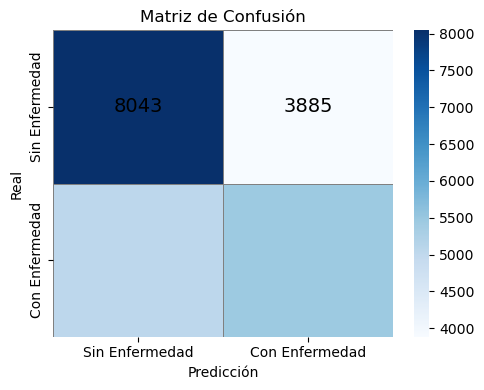

In [36]:
# Reporte de clasificación
print("=== Reporte de Clasificación ===")
print(classification_report(etiquetas_reales, pred_finales, digits=4))

# Matriz de confusión
conf_mat_sin_opt = confusion_matrix(etiquetas_reales, pred_finales, labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_sin_opt, 
            annot=True, 
            fmt="d", 
            cmap="Blues",
            annot_kws={"size": 14, "color": "black"},  # ← Forzar visibilidad del texto
            linewidths=0.5, 
            linecolor="gray",
            xticklabels=["Sin Enfermedad", "Con Enfermedad"],
            yticklabels=["Sin Enfermedad", "Con Enfermedad"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

## Resultados con Hiperparámetros

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

         0.0     0.6163    0.7470    0.6754     11928
         1.0     0.6216    0.4719    0.5365     10505

    accuracy                         0.6182     22433
   macro avg     0.6189    0.6094    0.6059     22433
weighted avg     0.6187    0.6182    0.6103     22433



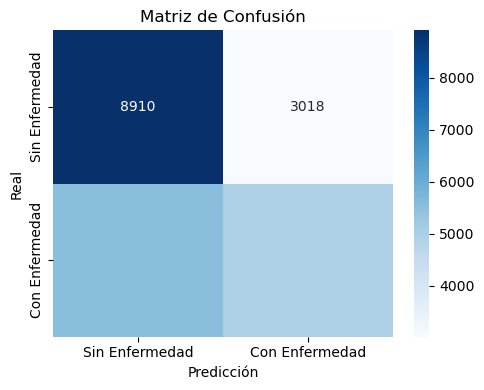

In [38]:
print("=== Reporte de Clasificación ===")
print(classification_report(etiquetas_reales_opt, pred_finales_opt, digits=4))

conf_mat_opt = confusion_matrix(etiquetas_reales_opt, pred_finales_opt, labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_opt, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Sin Enfermedad", "Con Enfermedad"],
            yticklabels=["Sin Enfermedad", "Con Enfermedad"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

## Comparación de Pérdidas

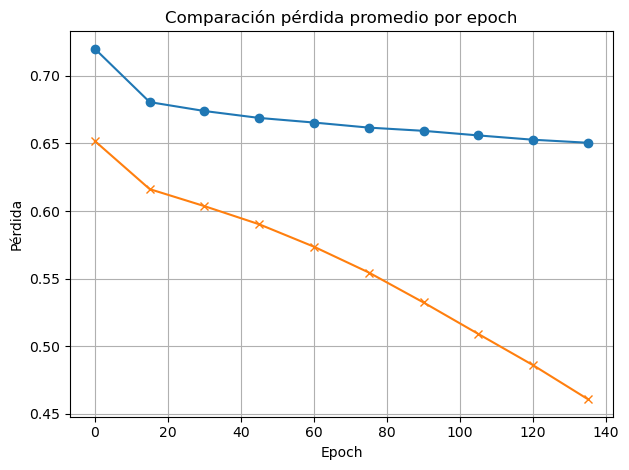

In [40]:
# Grafico de pérdidas en entrenamiento --ADVERTENCIA-- puede matar el kernel en jupyter

# Subconjunto de pérdida cada 20 epochs
subset1 = perdida_batch[::15]
subset2 = perdida_batch_opt[::15]

# Crear los índices reales correspondientes (0, 15, 30, ...)
epochs = list(range(0, len(perdida_batch), 15))

plt.plot(epochs, subset1, label='Sin optimización', marker='o')
plt.plot(epochs, subset2, label='Optimizado', marker='x')
plt.title("Comparación pérdida promedio por epoch")
plt.xlabel("Epoch")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
conf_mat_opt[1,1]

4957

In [45]:
conf_mat_opt[1,0]

5548

In [42]:
conf_mat_sin_opt[1, 1]

5455

In [43]:
conf_mat_sin_opt[1, 0]

5050